In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
from timeit import default_timer as timer
import models.trainer_lib as tl
import models.torch_model_definitions as tmd
import os
from configs import CONFIGS, load_data
import random
import json

with open('final_eval_results/strategies.json', 'r') as f:
    strategies = json.load(f)

available_strategies = [s for s in strategies if 'fold_9' in strategies[s]]
if len(available_strategies) == 0:
    raise Exception('No strategies available, make sure to run eval_final_config.py with -sm switch or download final_eval_results folder from GitHub repo')

print('Strategies available:', ', '.join(available_strategies))

# Choose strategy and fold, Initialization cell

In [6]:
FOLD = 3
CHOICE = "mimo_tcn"

### Above are configurable parameters ###

if CHOICE not in available_strategies:
    raise Exception(f'Pretrained strategy {CHOICE} not available, choose one: {", ".join(available_strategies)}')
if FOLD not in range(1, 10):
    raise Exception(f'Fold {FOLD} not available, choose one from 1-9')

config = CONFIGS[CHOICE]
path = f"final_eval_results/{CHOICE}/fold_{FOLD}.pt"
wrapper = config['wrapper'](config['model'](**config['model_params']).to(tl.TRAINER_LIB_DEVICE), config['seq_len'], config['pred_len'], **config['extra_strat_params'])

wrapper.load_state(path)
X, y = load_data(config['load_modifier'])

split_len = X.shape[0] // (config['n_splits'] + 1) 
start_point = split_len * FOLD
end_point = split_len * (FOLD + 1)

y_pred, y_true = wrapper.predict(X[start_point:end_point], y[start_point:end_point])

## Per hour ahead performance

In [7]:
df = pd.read_csv(f'final_eval_results/{CHOICE}.csv')

df_no12fold = df[(df['Fold'] != 1) & (df['Fold'] != 2)]
      
means = df_no12fold.drop(['Fold', 'Train Time', 'Pred Time'], axis=1).groupby('Hour').mean()
stds = df_no12fold.drop(['Fold', 'Train Time', 'Pred Time'], axis=1).groupby('Hour').std()

means = means.round({'MAE': 2, 'MSE': 1, 'RMSE': 2, 'MAPE': 4, 'MPE': 4})
stds = stds.round({'MAE': 2, 'MSE': 1, 'RMSE': 2, 'MAPE': 4, 'MPE': 4})

mean_and_std = pd.DataFrame(columns=['Hour', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'])
mean_and_std['Hour'] = means.index
mean_and_std.set_index('Hour', inplace=True)

for col in means.columns:
    mean_and_std[col] = means[col].astype(str) + "\u00B1" + stds[col].astype(str)

# print(mean_and_std.to_latex())
# print(mean_and_std.to_markdown())

mean_and_std

,MAE,MSE,RMSE,MAPE,MPE
Hour,,,,,
0,65.29±10.41,9289.0±2911.5,95.19±15.25,1.3432±0.2219,0.0361±0.1803
1,41.25±4.35,3360.2±664.5,57.67±5.9,0.8461±0.0943,-0.0049±0.1012
2,65.44±10.43,8434.6±2603.1,90.75±14.26,1.3444±0.2219,0.0208±0.1776
3,89.17±16.56,16072.2±5532.2,124.9±21.99,1.839±0.3521,0.0925±0.2821


## Per fold performance

In [8]:
df = pd.read_csv(f'final_eval_results/{CHOICE}.csv')

df = df[(df['Hour'] == 0)]

means = df.drop(['Hour', 'Train Time', 'Pred Time'], axis=1).groupby('Fold').mean()
stds = df.drop(['Hour', 'Train Time', 'Pred Time'], axis=1).groupby('Fold').std()

means = means.round({'MAE': 2, 'MSE': 1, 'RMSE': 2, 'MAPE': 4, 'MPE': 4})
stds = stds.round({'MAE': 2, 'MSE': 1, 'RMSE': 2, 'MAPE': 4, 'MPE': 4})

mean_and_std = pd.DataFrame(columns=['Fold', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MPE'])
mean_and_std.set_index('Fold', inplace=True)

for col in means.columns:
    mean_and_std[col] = means[col].astype(str) + "\u00B1" + stds[col].astype(str)
    
mean_and_std

,MAE,MSE,RMSE,MAPE,MPE
Fold,,,,,
1,54.07±4.36,7306.3±1338.3,85.2±7.56,1.1584±0.0971,-0.1882±0.0677
2,54.35±3.83,6007.1±950.2,77.31±5.95,1.1109±0.0726,-0.259±0.1055
3,51.43±2.39,5565.3±516.4,74.54±3.42,1.0584±0.0458,0.0149±0.08
4,53.69±2.03,5955.7±441.2,77.13±2.83,1.0962±0.0414,-0.0619±0.0695
5,61.33±2.57,8325.4±632.4,91.19±3.41,1.2297±0.0522,-0.1411±0.0807
6,64.37±1.18,9040.8±365.1,95.07±1.92,1.3852±0.0256,0.3607±0.0912
7,69.05±1.33,9883.3±390.0,99.4±1.95,1.3863±0.0291,0.1698±0.0893
8,77.27±1.41,12678.0±389.4,112.59±1.72,1.5525±0.0297,-0.087±0.066
9,79.86±3.25,13574.6±896.4,116.46±3.85,1.6939±0.0663,-0.0026±0.1024


## Training and prediction time

Train time: 169.3±90.1
Pred time: 0.2575±0.0446


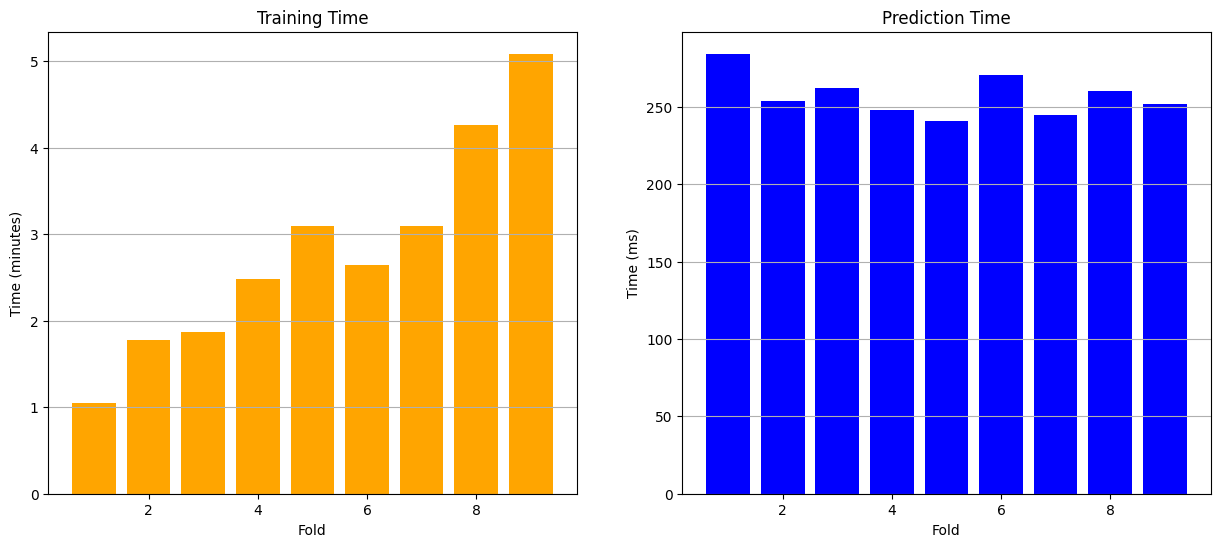

In [9]:
df = pd.read_csv(f'final_eval_results/{CHOICE}.csv')

print(f"Train time: {df['Train Time'].mean():.1f}\u00B1{df['Train Time'].std():.1f}")
print(f"Pred time: {df['Pred Time'].mean():.4f}\u00B1{df['Pred Time'].std():.4f}")

tt_df = df.groupby('Fold')['Train Time'].mean()
tt_df = tt_df / 60

pt_df = df.groupby('Fold')['Pred Time'].mean()
pt_df = pt_df * 1000

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
axs[0].bar(tt_df.index, tt_df, color='orange')
axs[0].set_title("Training Time")
axs[0].set_xlabel("Fold")
axs[0].set_ylabel("Time (minutes)")
axs[0].grid(axis='y')

axs[1].bar(pt_df.index, pt_df, color='blue')
axs[1].set_title("Prediction Time")
axs[1].set_xlabel("Fold")
axs[1].set_ylabel("Time (ms)")
axs[1].grid(axis='y')

## Prediction plots

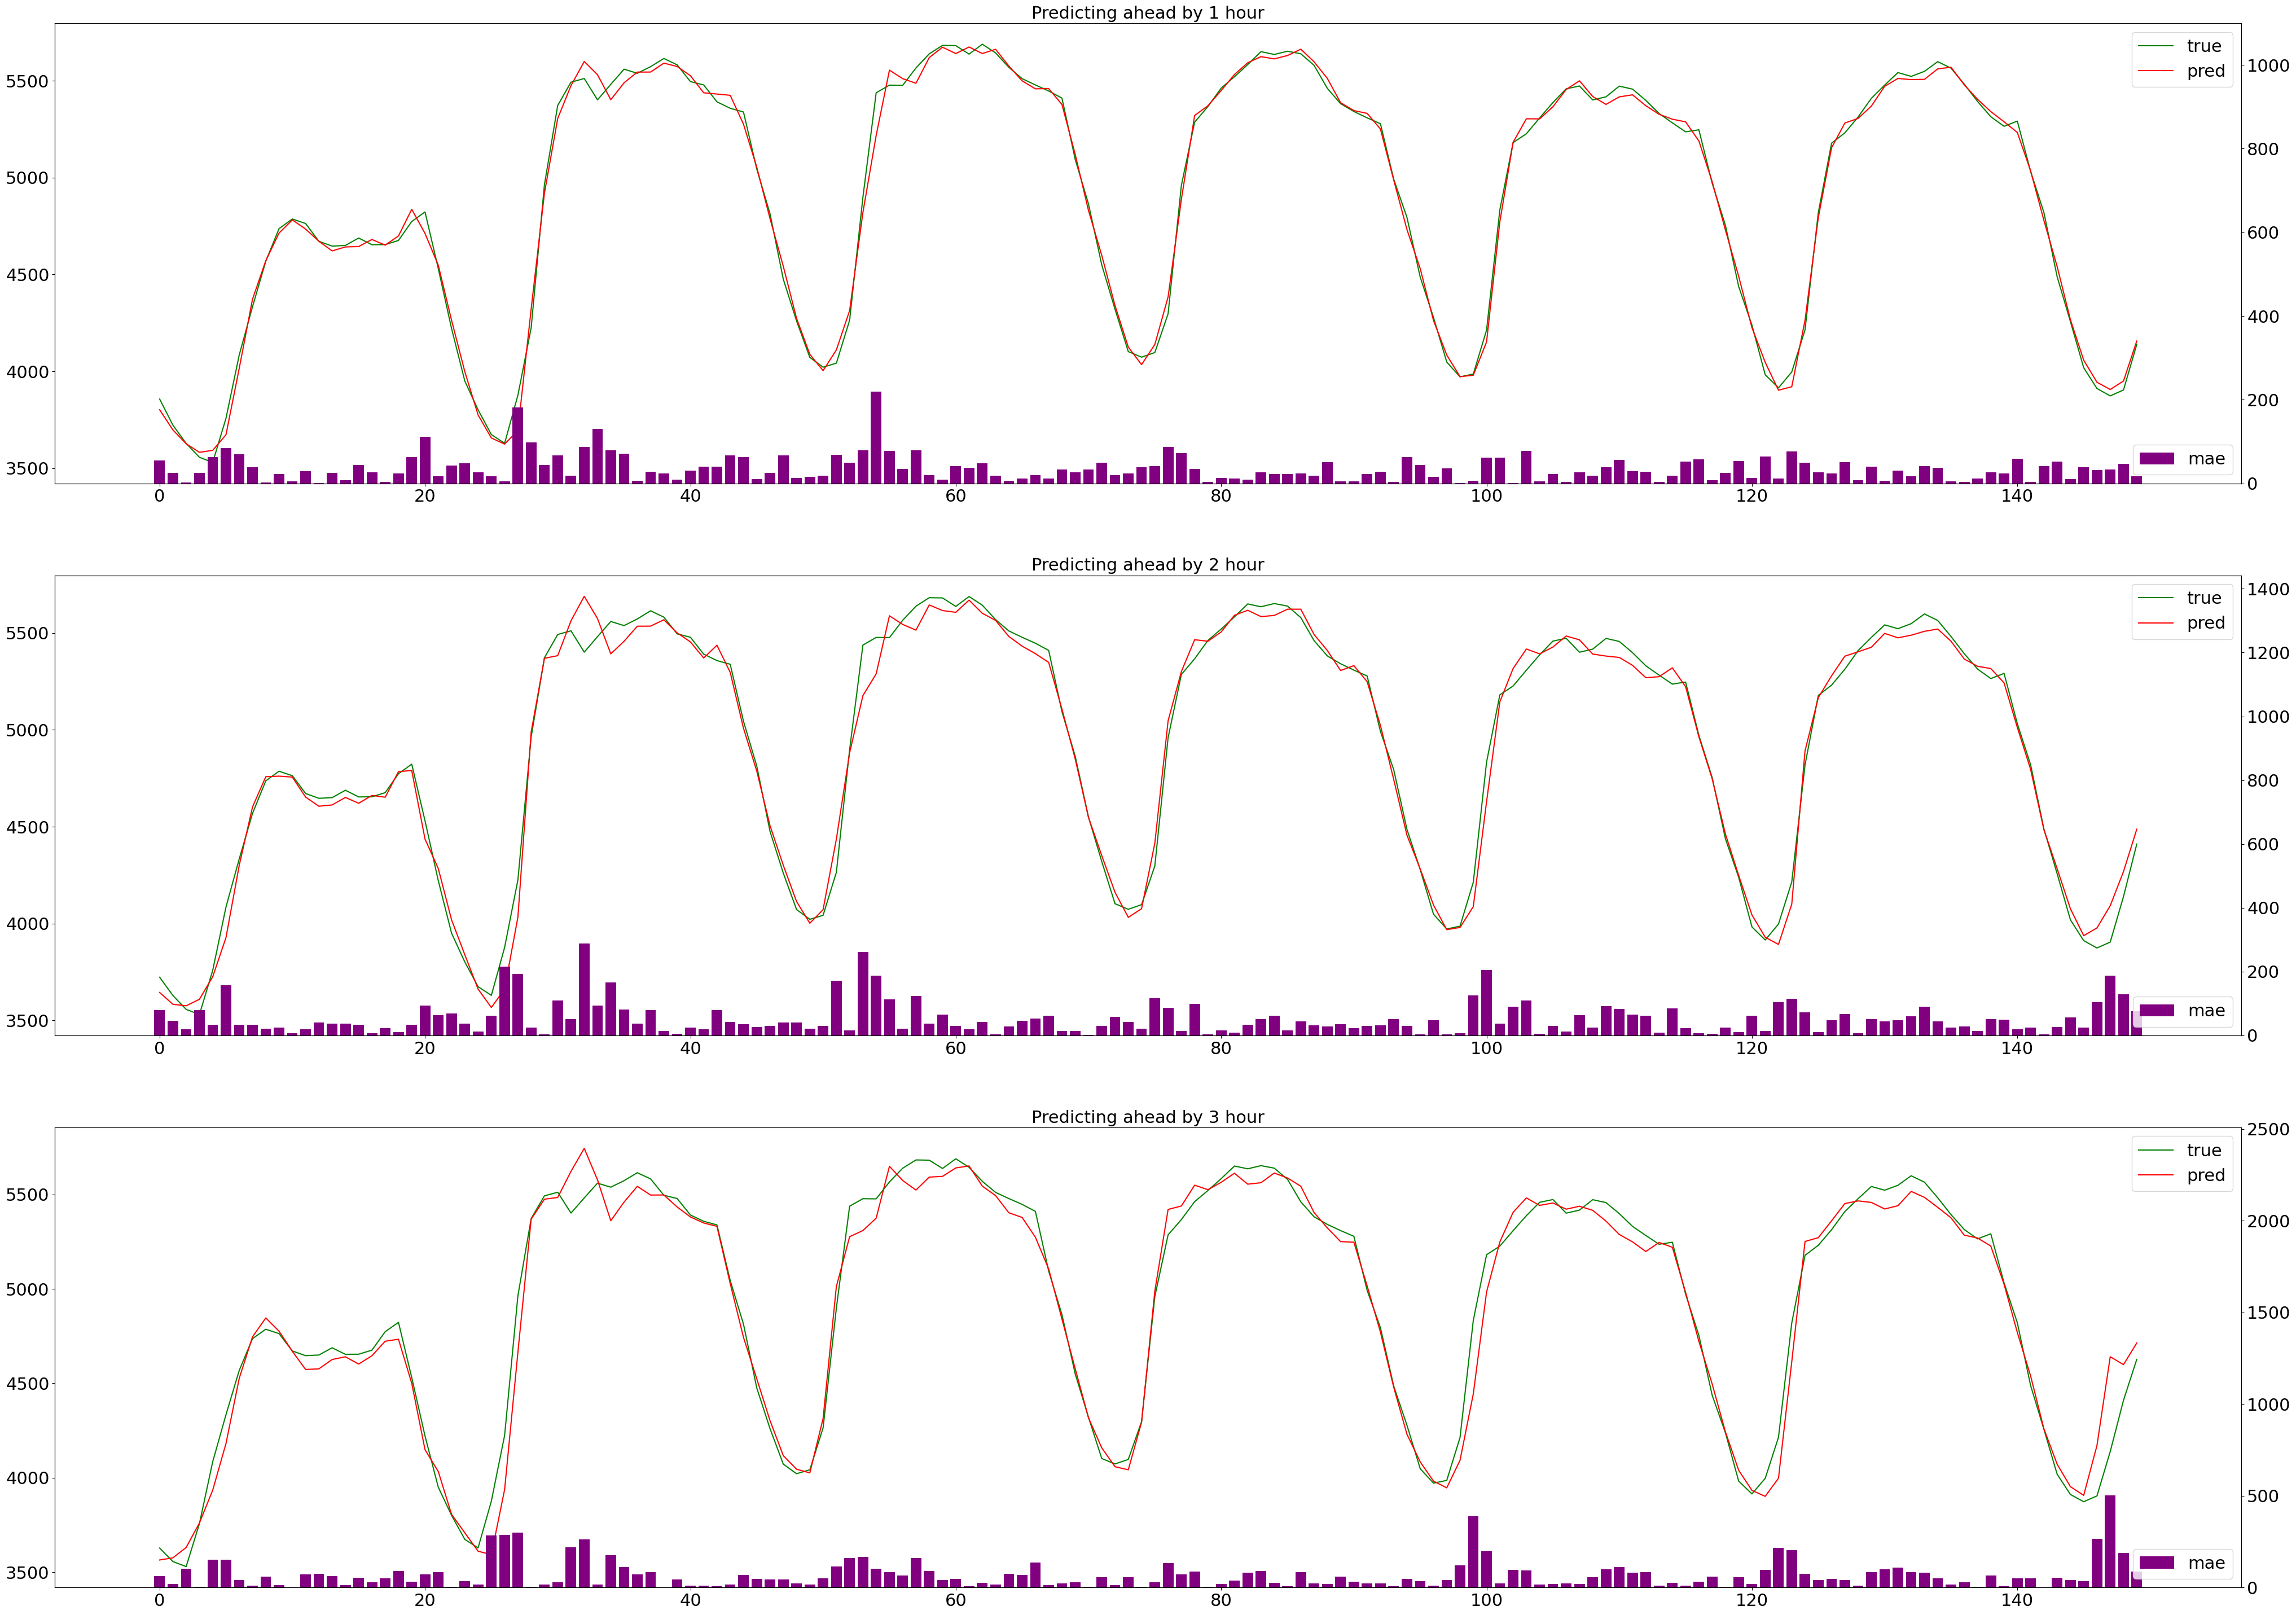

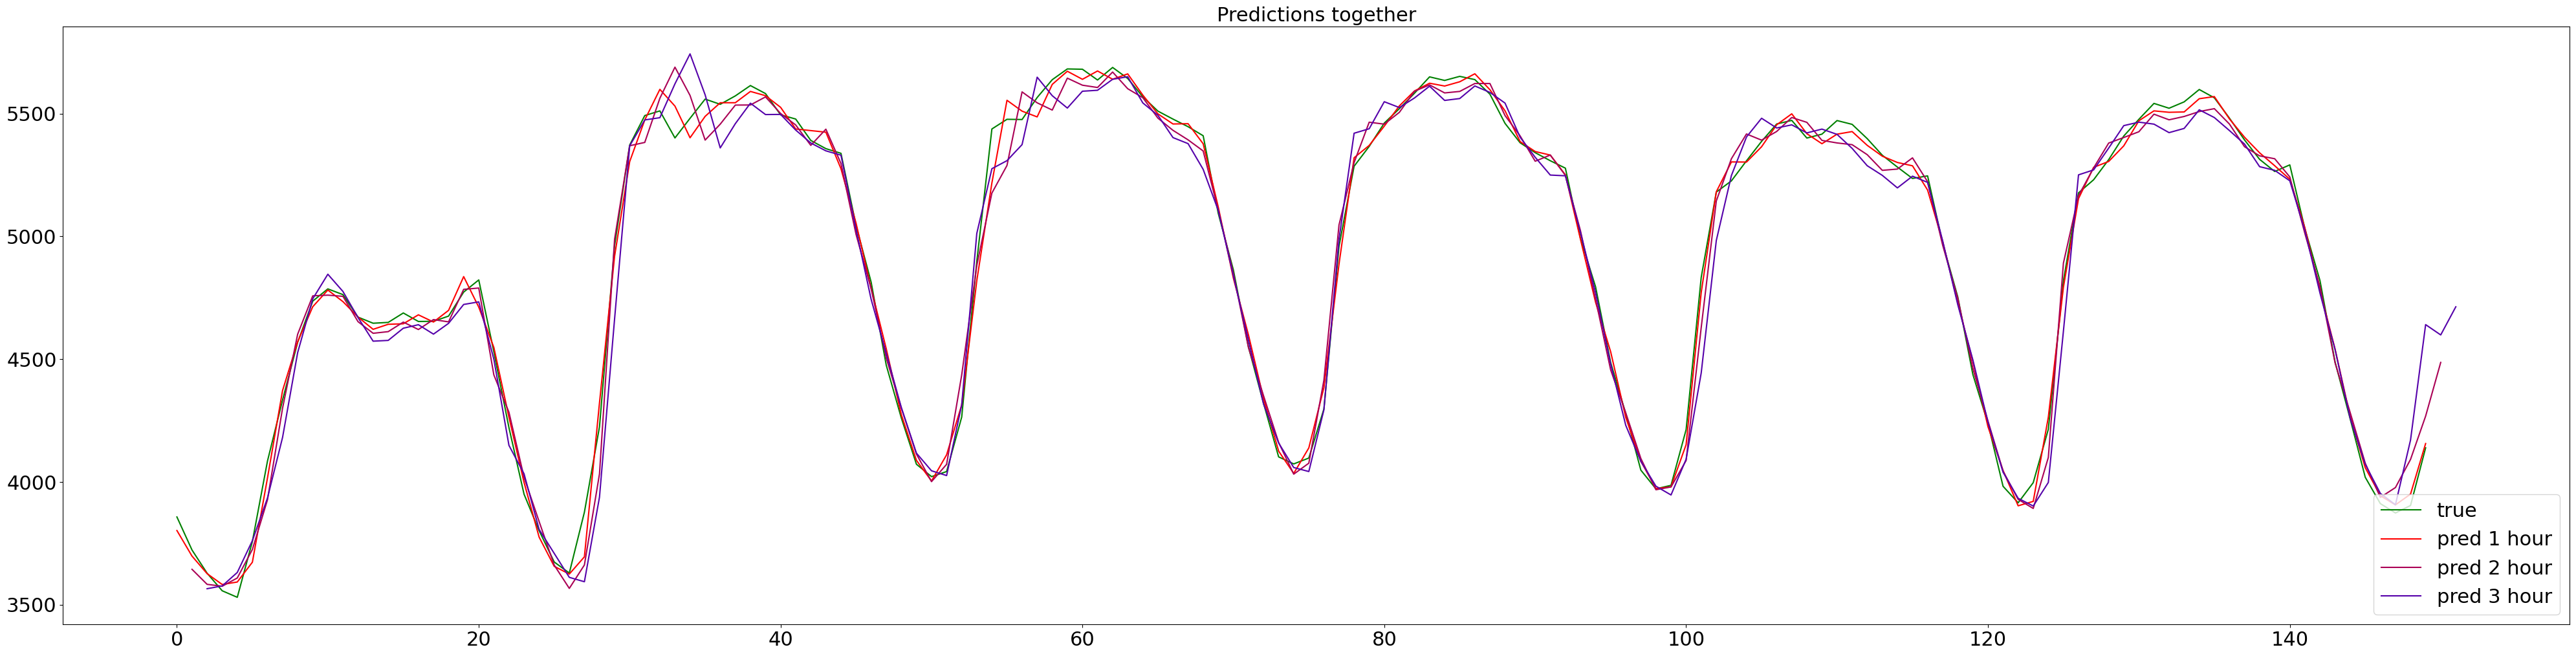

In [10]:
PLOT_START = None # None means choose randomly
PLOT_LENGTH = 150
WHICH_PLOTS = [ # Comment out the ones you don't want
    'per_hour',
    'together',
]

### Above are configurable parameters ###

if PLOT_START is None:
    PLOT_START = random.randint(0, split_len - PLOT_LENGTH)
    
if PLOT_START + PLOT_LENGTH > split_len:
    raise ValueError(f'PLOT_START + PLOT_LENGTH > split_len, PLOT_START: {PLOT_START}, PLOT_LENGTH: {PLOT_LENGTH}, split_len: {split_len}')
    
if 'per_hour' in WHICH_PLOTS:
    wrapper.plot_predictions_per_hour(y_pred[PLOT_START:PLOT_START+PLOT_LENGTH], y_true[PLOT_START:PLOT_START+PLOT_LENGTH])
if 'together' in WHICH_PLOTS:
    wrapper.plot_predictions_together(y_pred[PLOT_START:PLOT_START+PLOT_LENGTH], y_true[PLOT_START:PLOT_START+PLOT_LENGTH])